In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from ambiance import Atmosphere
from matplotlib.widgets import Slider, Button
import ipywidgets
import re
from scipy.integrate import odeint, solve_ivp, quad

In [3]:
# Program constants

g = 9.82 # [m/s^2]
massBall = 0.06 # [kg] -> 60 grams
min_straight_distance = 150 # [m]

In [4]:
# Define functions and variables

global fileP 

def Get_Prop_Power_and_Thrust(filename, density, rpm, diameter_propeller): # diameter in inches
    ''' Skips the first 10 rows of the dat file and gets the first 30 rows of J, Ct and CP
        Returns the velocity, T, P for the given rpm, air density and diameter '''
    array = np.loadtxt(filename, skiprows=3, max_rows=30, comments=['P', 'V', '('])
    diameter_propeller = diameter_propeller*0.0254 # Convert inches to m
    rps = rpm/60.0
    J, Pe, Ct, Cp = array[:,1], array[:,2], array[:,3], array[:,4]
    velocity = J*rps*diameter_propeller; T, P = Ct*(density*(rps**2)*(diameter_propeller**4)), Cp*(density*(rps**3)*(diameter_propeller**5))
    return velocity, T, P

def Cf(self, Velocity): # Function to return skin friction coef.
    # For wing use mean chord
    ReWing = (self.density*Velocity*self.meanChordWing) / self.dynamicViscosity
    # For fusaluge use length
    ReBody = (self.density*Velocity*self.bodyLength) / self.dynamicViscosity
    # Cf = 0.664/(Re)**2 # Blasius solution - lam flow Re < 500 000 | Cf = 0.027 / (Re**(1/7)) # Prandtl's one-seventh-power law - turb flow
    cfWing = np.where(ReWing < 500000, 0.664/(ReWing**0.5), 0.027 / (ReWing**(1/7)))
    cfBody = np.where(ReBody < 500000, 0.664/(ReBody**0.5), 0.027 / (ReBody**(1/7)))
    return cfWing, cfBody

def Min_Time_to_Turn(velocityStall, turnRadius):
    omega = velocityStall/turnRadius # [rad/s]
    turnAngle = 2*np.pi/2 # [180 degs]
    return turnAngle/omega # min time to turn

def Get_Max_Velocity(velocity, requiredThrust, propThrust):
    index = np.where(propThrust>requiredThrust)[0]
    velocityMax = velocity[index[-1]-1] # Shift 1 element back to before cross
    print(f'Maxmium flight velocity: {velocityMax} [m/s]')
    return velocityMax

def Time_in_Course(velocityMax, velocityStall, turnRadius):
    minTime2Turn = Min_Time_to_Turn(velocityStall, turnRadius)
    time = (2*min_straight_distance)/velocityMax + 2*minTime2Turn
    print(f'Min time in course: {time} [s]')

def longitudinalStaticStability_Tailless(self, Vd, V, data):
    dCLw_dAOA = data[0]; dCLt_dAOA = data[1]
    AOA_L0w = data[2]
    CMw = data[3]; Ee = data[4]
    dCMt_dde = data[5]; nt = data[6]
    # No tail - @ design velocity -> L = W
    CLw_f0 = self.W/(0.5*self.density*(Vd**2)*self.Sw) # CLw_f0 at zero fuselage angle of attack and zero elevator deflection
    AOA_mw = (CLw_f0/dCLw_dAOA) + AOA_L0w # Wing mount angle
    lw = (CMw/CLw_f0)*self.meanChordWing # Position of CG to balance Cmw | no tail
    dCM_dAOA = -(lw/self.meanChordWing)*dCLw_dAOA #; print(f'dCM_dAOA: {dCM_dAOA} if negative stabale')
    dCL_dAOA = dCLw_dAOA 
    CL = self.W/(0.5*self.density*(V**2)*self.Sw); CL0 = dCLw_dAOA*(AOA_mw - AOA_L0w)
    dCM_dAOA = -(lw/self.meanChordWing)*dCLw_dAOA
    dCM_dde = 0
    CM0 = CMw - (lw/self.meanChordWing)*dCLw_dAOA*(AOA_mw - AOA_L0w)#; print(f'CM0: {CM0}') # At trim must be zero       
    lnp = -(dCM_dAOA/dCL_dAOA)*self.meanChordWing # neutral point from CG position
    staticMargin = (lw*dCLw_dAOA) / (self.meanChordWing*dCLw_dAOA) # static margin
    A = np.array([[dCL_dAOA, dCL_dde], [dCM_dAOA[0], dCM_dde[0]]])
    B = np.array([CL-CL0, -CM0])
    x = np.linalg.solve(A, B)     
    AOA, de = x[0][0], x[1][0]
    Lw = 0.5*self.density*(V**2)*self.Sw*dCLw_dAOA*(AOA + AOA_mw - AOA_L0w)
    mountAngle = AOA_mw
    return x, lnp, staticMargin, lw, Lw, mountAngle   

def staticRollStability(self):
    Kl = 0.97
    dCl_dbTw = -((2*Kl*(dCLw_da))/(3*np.pi))*T # For wing with no twist and no sweep 
    
    
    

# Define the Aircraft template

In [5]:
# Aircraft Class- template

class Aircraft:
    def __init__(self, altitude, rpm, CLmax, CD0, 
                       Sw, wingSpan, e, meanChordWing,
                       St, meanChordTail,
                       bodyLength, bodyDiameter,
                       bankAngle, planeMass, numberOfBalls):
        self.altitude = altitude
        self.rpm = rpm
        self.CLmax = CLmax; self.CD0 = CD0
        self.Sw = Sw; self.wingSpan = wingSpan; self.e = e; self.meanChordWing = meanChordWing; self.AR = (self.wingSpan**2)/self.Sw
        self.St = St; self.meanChordTail = meanChordTail
        
        self.bodyLength = bodyLength; self.bodyDiameter = bodyDiameter
        self.bankAngle = bankAngle
        self.planeMass = planeMass; self.numberOfBalls = numberOfBalls        

        Altitude = Atmosphere(self.altitude); density = Altitude.density; self.density = density
        self.dynamicViscosity = Altitude.dynamic_viscosity
        self.Sb = self.bodyLength * (np.pi*(self.bodyDiameter/2)**2)
        
        self.W = (self.planeMass + self.numberOfBalls*massBall) * g 
                          
    def propulsion(self, filename):
        result = re.search('_(.*)x', filename)
        diameter_propeller = float(result.group(1)) # Gets proppeller diameter from filename
        velocity_at_RPM, propThrust, propPower = Get_Prop_Power_and_Thrust(filename, self.density, self.rpm, diameter_propeller)
        return velocity_at_RPM, propThrust, propPower
    
    def flightPerfomance_levelFlight(self, Vmin, Vmax, Vres): # Steady level flight
        velocity = np.linspace(Vmin, Vmax, Vres)
        cfWing, cfBody = Cf(self, velocity)
        frictionDragForceWing = 0.5*self.density*(velocity**2)*self.Sw*cfWing
        frictionDragForceBody = 0.5*self.density*(velocity**2)*self.Sb*cfBody
        frictionDragForce = frictionDragForceBody + frictionDragForceWing
        inducedDragForce = 2*(self.W/self.Sw)*(self.W/(self.density*(velocity**2)*np.pi*self.e*self.AR))
        profileDragForce = 0.5*self.density*(velocity**2)*self.Sw*self.CD0
        requiredThrust = profileDragForce + inducedDragForce + frictionDragForce
        requiredPower = requiredThrust*velocity
        print(f'Aspect Ratio of wing: {self.AR} | Aspect of tail: {self.ARt}')
        return velocity, requiredThrust, requiredPower, frictionDragForce, inducedDragForce, profileDragForce

    def turnPerformance(self): # Steady level turn
        bankAngle = np.deg2rad(self.bankAngle)
        k = 1/(self.e*np.pi*self.AR); loadFactor = 1 / np.cos(bankAngle)
        velocityStall = ((2*loadFactor*self.W)/(self.density*self.Sw*self.CLmax))**0.5
        turnRadius = velocityStall**2 / (g*np.tan(bankAngle)) # Turn radius at stall velocity and bank angle
        requiredThrust4Turn = 0.5*self.density*(velocityStall**2)*self.Sw*self.CD0 + ((loadFactor*self.W)**2)*((2*k)/(self.density*(velocityStall**2)*self.Sw))
        requiredPower4Turn = requiredThrust4Turn*velocityStall
        return velocityStall, requiredThrust4Turn, requiredPower4Turn, loadFactor, turnRadius
    
    def takeOff_and_landing(self, ur, hOB, velocity_at_RPM, propThrust, propPower): # Take off distance
        velocityStall = ((2*self.W)/(self.density*self.Sw*self.CLmax))**0.5
        velocityLiftOff = 0.7*velocityStall*1.2
        lift, drag = 0.5*self.density*(velocityLiftOff**2)*self.CLmax*self.Sw, 0.5*self.density*(velocityLiftOff**2)*self.CD0*self.Sw
        
        # Propulsion performance
        aT = interp1d(velocity_at_RPM, propThrust); aP = interp1d(velocity_at_RPM, propPower)
        aMean = (g/self.W) * ((aT(velocityLiftOff)-drag)-ur*(self.W-lift))
        Sg = (velocityLiftOff**2) / (2*aMean)
                
        R = (velocityStall*1.2)**2 / (g*(1.19-1))
        climbAngle = np.arccos(1-(hOB/R))
        S_a = np.sin(climbAngle) # horz.. distance to clear height
        print(f'Takeoff & landing || TOmass: {self.W/9.82} [kg]| Takeoff velocity: {velocityLiftOff} [m/s]| Ground run: {Sg} [m]| Climb angle: {np.rad2deg(climbAngle)} [deg]| Airbourne distance: {S_a}[m]')

    def longitudinalStaticStability(self, Vd, V, length_quarter_chord_to_tail, data, tailType, T):        
        dCLw_dAOA = data[0]; dCLt_dAOA = data[1]
        AOA_L0w = data[2]
        CMw = data[3]; Ee = data[4]
        dCMt_dde = data[5]; nt = data[6]
        
        # No lift at tail - @ design velocity -> L = W
        CLw_f0 = self.W/(0.5*self.density*(Vd**2)*self.Sw) # CLw_f0 at zero fuselage angle of attack and zero elevator deflection
        AOA_mw = (CLw_f0/dCLw_dAOA) + AOA_L0w # Wing mount angle
        Ed_0 = 0.6*(CLw_f0/self.AR) # Downwash angle at tail when zero fuselage angle of attack
        AOA_mt = Ed_0 # Angle of zero lift at tail         
        lw = (CMw/CLw_f0)*self.meanChordWing # Position of CG to balance Cmw | no lift at tail
        lt = length_quarter_chord_to_tail + lw
        VolTail = (self.St*lt)/(self.Sw*self.meanChordWing)#; print(f'Tail vol: {VolTail}')
        dEd_dAOA = 0.6*(dCLw_dAOA/self.AR)

        # pitch stability derivatives
        if tailType == 'Tailless':
            lt, VolTail, dCLt_dAOA = np.array([0]), np.array([0]), 0
            dCL_dde = 0.0
        elif tailType == 'V-Tail':
            T = np.deg2rad(T)
            t = dCMt_dde/(nt*(lt/self.meanChordWing)*dCLt_dAOA*(self.St/self.Sw)*np.cos(T))
            dCLt_dAOA = dCLt_dAOA*(np.cos(T))**2 # Lift curve slope of the V-tail
            dCL_dde = dCLt_dAOA*t*np.cos(T)# Elevator authority of the V-tail
            dCL_dde = dCL_dde[0]
        else:
            dCL_dde = (self.St/self.Sw)*nt*dCLt_dAOA*Ee
        
        dCM_dAOA = -(lw/self.meanChordWing)*dCLw_dAOA - VolTail*nt*dCLt_dAOA*(1-dEd_dAOA) #; print(f'dCM_dAOA: {dCM_dAOA} if negative stabale')
        dCL_dAOA = dCLw_dAOA + (self.St/self.Sw)*nt*dCLt_dAOA*(1-dEd_dAOA); 
        CL = self.W/(0.5*self.density*(V**2)*self.Sw); CL0 = dCLw_dAOA*(AOA_mw - AOA_L0w) + (self.St/self.Sw)*nt*dCLt_dAOA*(AOA_mt - Ed_0)
        dCM_dAOA = -(lw/self.meanChordWing)*dCLw_dAOA - VolTail*nt*dCLt_dAOA*(1-dEd_dAOA)
        dCM_dde = ((self.St*self.meanChordTail)/(self.Sw*self.meanChordWing))*nt*dCMt_dde - VolTail*nt*dCLt_dAOA*Ee
        CM0 = CMw - (lw/self.meanChordWing)*dCLw_dAOA*(AOA_mw - AOA_L0w) - VolTail*nt*dCLt_dAOA*(AOA_mt - Ed_0)#; print(f'CM0: {CM0}') # At trim must be zero
        
        lnp = -(dCM_dAOA/dCL_dAOA)*self.meanChordWing # neutral point from CG position
        staticMargin = ( lw*dCLw_dAOA + ((self.St*lt)/self.Sw)*nt*dCLt_dAOA*(1-dEd_dAOA) ) / (self.meanChordWing*(dCLw_dAOA + (self.St/self.Sw)*nt*dCLt_dAOA*(1-dEd_dAOA))) # static margin

        A = np.array([[dCL_dAOA, dCL_dde],
                      [dCM_dAOA[0], dCM_dde[0]]])
        B = np.array([CL-CL0, -CM0])
        x = np.linalg.solve(A, B)
        
        AOA, de = x[0][0], x[1][0]
        Lw, Lt = 0.5*self.density*(V**2)*self.Sw*dCLw_dAOA*(AOA + AOA_mw - AOA_L0w), 0.5*self.density*(V**2)*self.St*nt*dCLt_dAOA*((1-dEd_dAOA)*AOA + AOA_mt - Ed_0 + Ee*de)
        mountAngles = (AOA_mw, AOA_mt)
        
        return x, lnp, staticMargin, lt, lw, Lw, Lt, mountAngles
        
    def longitudinalDynamicStability(self, u0, Iyy, CL0, CLu, CLa, CDu, CMa, CMq, state0, endTime): # Decoupling Approximation for Small Perturbations from Steady, Level Flight
        # Aircraft specific data
        m = self.W/g
        H = self.altitude
        Q = 0.5*self.density*u0**2
        
        Xu = (-(CDu + 2*self.CD0)*Q*self.Sw)/(m*u0)
        Xw = (-(CDu + 2*CL0)*Q*self.Sw)/(m*u0)

        Zu = (-(CLu + 2*CL0)*Q*self.Sw)/(m*u0)
        Zw = (-(CLa + 2*self.CD0)*Q*self.Sw)/(m*u0)
        Za = u0*Zw

        Mw = CMa*((Q*self.Sw*self.meanChordWing)/(u0*Iyy))
        Mq = CMq*(self.meanChordWing/(2*u0))*((Q*self.Sw*self.meanChordWing)/Iyy)
        #print(m, H, Q, Xu, Xw, Zu, Zw, Za, Mw, Mq)
        
        # Trim condition
        u0, w0, q0, theta0, x0, z0 = u0, 0, 0, 0, 0, H

        def EoM(t, states):
            u, w, q, theta, x, z = states[0], states[1], states[2], states[3], states[4], states[5]

            # Aerodynamic forces and moments
            Xm = g*np.sin(theta0) + Xu*(u-u0) + Xw*(w-w0)
            Zm = -g*np.cos(theta0) + Zu*(u-u0) + Zw*(w-w0)
            MIyy = Mw*(w-w0) + Mq*(q-q0)

            # Equations of motion
            dudt = -(q*w) - g*np.sin(theta) + Xm
            dwdt = q*u + g*np.cos(theta) + Zm
            dqdt = MIyy
            dthetadt = q
            dxdt = u*np.cos(theta) + w*np.sin(theta)
            dzdt = u*np.sin(theta) - w*np.cos(theta)

            return [dudt, dwdt, dqdt, dthetadt, dxdt, dzdt]

        result = solve_ivp(EoM, [0,endTime], state0) # Solve EoM equations
        t, states = result.t, result.y
        u, w, q, theta, x, z = states[0,:], states[1,:], states[2,:], states[3,:], states[4,:], states[5,:]

        fig, ax = plt.subplots(2, 3, figsize=(20,6))
        ax[0][0].plot(t,u); ax[0][0].set_xlabel('time [s]'); ax[0][0].set_ylabel('Velocity u [m/s]')
        ax[0][1].plot(t,w); ax[0][1].set_xlabel('time [s]'); ax[0][1].set_ylabel('Velocity w [m/s]')
        ax[0][2].plot(t,q); ax[0][2].set_xlabel('time [s]'); ax[0][2].set_ylabel('Pitch Rate [rad/s]')
        ax[1][0].plot(t,theta); ax[1][0].set_xlabel('time [s]'); ax[1][0].set_ylabel('Angle of Attack [rad]')
        ax[1][1].plot(t,x); ax[1][1].set_xlabel('time [s]'); ax[1][1].set_ylabel('X Position [m]')
        ax[1][2].plot(t,z); ax[1][2].set_xlabel('time [s]'); ax[1][2].set_ylabel('Z Position [m]')
        plt.show()
        return t, u, w, q, theta, x, z

    def Get_chord(self, file, velocity):
        data = np.loadtxt(file, skiprows=1, usecols = (0,1))
        b, chord_wing = data[:,0], (data[:,1]*self.dynamicViscosity)/velocity
        c = interp1d(b, chord_wing, fill_value="extrapolate")
        return c
    
    def aileronSizing(self, c, CLa, CLdai, b1, b2):
        rollDamping = lambda y: c(y) * y**2
        rollAuthority = lambda y: c(y) * y
        print(f"{self.CD0, self.Sw, self.wingSpan}")
        rollDampingCoefficient = -1*((4*(CLa + self.CD0))/(self.Sw*self.wingSpan**2)) * quad(rollDamping, 0, self.wingSpan/2)[0]
        rollAuthorityDerivative = ((2*CLdai)/(self.Sw*self.wingSpan)) * quad(rollAuthority, b1, b2)[0]  # dCL_dda is the lift slope due to aileron deflection
        return rollDampingCoefficient, rollAuthorityDerivative

# Set-up sim - Flight Performance

In [9]:
def run_sim(aircraft, V, altitude, rpm, Sw, wingSpan, tailSpan, e, meanChordWing, St, meanChordTail, bodyLength, bodyDiameter, bankAngle, planeMass, numberOfBalls):     
    # set-up instance values not done when first init the class
    aircraft.altitude, aircraft.rpm, aircraft.Sw, aircraft.wingSpan = altitude, rpm, Sw, wingSpan
    aircraft.e, aircraft.meanChordWing, aircraft.St, aircraft.meanChordTail = e, meanChordWing, St, meanChordTail
    aircraft.bodyLength, aircraft.bodyDiameter, aircraft.bankAngle, aircraft.planeMass = bodyLength, bodyDiameter, bankAngle, planeMass
    aircraft.numberOfBalls = numberOfBalls
    
    aircraft.AR = (wingSpan**2)/Sw
    aircraft.ARt = (tailSpan**2)/St
    
    Altitude = Atmosphere(altitude)
    aircraft.density = Altitude.density
    aircraft.dynamicViscosity = Altitude.dynamic_viscosity
    aircraft.Sb = bodyLength * (np.pi*(bodyDiameter/2)**2)
    aircraft.W = (planeMass + numberOfBalls*massBall) * g 
        
    Vmin, Vmax, Vres = V[0], V[1], V[2]
    ur, hOB = V[3], V[4]
    
    velocity_at_RPM, propThrust_at_RPM, propPower_at_RPM = aircraft.propulsion(fileP)
    Vres = len(velocity_at_RPM)
    velocity, requiredThrust, requiredPower, frictionDragForce, inducedDragForce, profileDragForce = aircraft.flightPerfomance_levelFlight(Vmin, Vmax, int(Vres))
    velocityStall, requiredThrust4Turn, requiredPower4Turn, loadFactor, turnRadius = aircraft.turnPerformance()
    print(f'@ Bank angle {bankAngle} || Stall velocity: {velocityStall} [m/s]| | Min turn radius: {turnRadius} [m]| Thrust required: {requiredThrust4Turn} [N]| Power required: {requiredPower4Turn} [W]')
    velocityMax = Get_Max_Velocity(velocity, requiredThrust, propThrust_at_RPM)
    Time_in_Course(velocityMax, velocityStall, turnRadius)
    aircraft.takeOff_and_landing(ur, hOB, velocity_at_RPM, propThrust_at_RPM, propPower_at_RPM)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
    ax1.plot(velocity_at_RPM, propThrust_at_RPM, label='Available thrust')
    ax1.plot(velocity, requiredThrust, label='Required thrust')
    ax1.plot(velocity, frictionDragForce, label='Friction drag ')
    ax1.plot(velocity, inducedDragForce, label='Induced drag ')
    ax1.plot(velocity, profileDragForce, label='Profile drag ')
    ax1.plot([velocityStall, velocityStall], [0, requiredThrust4Turn], label='Stall Velocity @ bank angle')

    ax2.plot(velocity_at_RPM, propPower_at_RPM, label='Avaiable power')
    ax2.plot(velocity, requiredPower, label='Required power')
    
    ax1.grid(); ax1.legend(); ax1.set_xlabel('V [m/s]'); ax1.set_ylabel('Thrust [N]')
    ax2.grid(); ax2.legend(); ax2.set_xlabel('V [m/s]'); ax2.set_ylabel('Power [W]')

    plt.show()

# ------------------------- Can change the deflaut, min, max and step values of the sliders here ---------------------------------------------------------
# Env
sliderAltitude = ipywidgets.IntSlider(description='Altitude [m]', value=1300, min=0, max=20000, step=10, continuous_update=False)
# Drive
sliderRPM = ipywidgets.IntSlider(value=9000, min=1000, max=20000, step=1000, continuous_update=False)
# Wing
sliderSw = ipywidgets.FloatSlider(description='WingArea [m^2]', value=0.33, min=0.1, max=2, step=0.01, continuous_update=False)
sliderwingSpan = ipywidgets.FloatSlider(description='WingSpan [m]', value=2, min=1, max=5, step=.1, continuous_update=False)
slidere = ipywidgets.FloatSlider(description='Span effi..', value=0.9, min=0.1, max=1, step=0.1, continuous_update=False)
slidermeanChordWing = ipywidgets.FloatSlider(description='WingChord [m]', value=0.17, min=0.1, max=0.75, step=0.01, continuous_update=False)
# Tail
sliderSt = ipywidgets.FloatSlider(description='TailArea [m^2]', value=0.05, min=0.01, max=2, step=0.01, continuous_update=False) 
slidertailSpan = ipywidgets.FloatSlider(description='TailSpan [m]', value=0.54, min=0.01, max=2, step=.01, continuous_update=False)
slidermeanChordTail = ipywidgets.FloatSlider(description='TailChord [m]', value=0.09, min=0.01, max=0.75, step=0.01, continuous_update=False)
# Fuselage
sliderBodyLength = ipywidgets.FloatSlider(description='BodyLength [m]', value=1.2, min=0.5, max=3.0, step=0.1, continuous_update=False)
sliderBodyDiameter = ipywidgets.FloatSlider(description='BodyDia [m]', value=0.1, min=0.070, max=0.3, step=0.01, continuous_update=False)
# Operation
sliderbankAngle = ipywidgets.IntSlider(description='Bank [deg]', value=0, min=0, max=89, step=1, continuous_update=False)
# Load
sliderPlaneMass = ipywidgets.FloatSlider(description='PlaneMass [kg]', value=1, min=0.5, max=2.5, step=0.1, continuous_update=False)
slidernumberOfBalls = ipywidgets.IntSlider(value=12, min=0, max=50, step=1, continuous_update=False)

# Run sim here - Flight Performance
## Run the above tabs once, only rerun the below tab if the input variables have changed

In [10]:
# -------------------------------------- Edit settings ---------------------
# Enter the location of propeller file as relative-path or absolute-oath into fileP!
fileP = 'Prop Data Experiment/PER3_10x5E.dat'

# Set up these parameters
CLmax, CD0 = 1.1, 0.05
V = np.array([2, 35, 50, 0.02, 10]) # [Vmin, Vmax, Vres, ur, hOB] # Vres has been disabled and is set by the number of points in prop data, or it breaks the get veloMax function.

# -----------------------------------------------------------------------------Do not change ---------------------------------------------------------------------------------------------------
altitude, rpm, CLmax, CD0, Sw, wingSpan, e, meanChordWing, St, meanChordTail, bodyLength, bodyDiameter, bankAngle, planeMass, numberOfBalls = 1, 1, CLmax, CD0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1
aircraft = Aircraft(altitude, rpm, CLmax, CD0, Sw, wingSpan, e, meanChordWing, St, meanChordTail, bodyLength, bodyDiameter, bankAngle, planeMass, numberOfBalls)

#ipywidgets.interact
widget = ipywidgets.interactive(run_sim, aircraft=ipywidgets.fixed(aircraft), V=ipywidgets.fixed(V), altitude=sliderAltitude, rpm=sliderRPM, Sw=sliderSw, wingSpan=sliderwingSpan, 
                                         tailSpan=slidertailSpan, e=slidere,
                                         meanChordWing=slidermeanChordWing, St=sliderSt, meanChordTail=slidermeanChordTail, bodyLength=sliderBodyLength, bodyDiameter=sliderBodyDiameter,
                                         bankAngle=sliderbankAngle, planeMass=sliderPlaneMass, numberOfBalls=slidernumberOfBalls)

controls = ipywidgets.HBox(widget.children[:-1], layout = ipywidgets.Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(ipywidgets.VBox([controls, output]))

In [11]:
def Static_Stability_Analysis(aircraft, data, Vd, Vinf_range, length_quarter_chord_to_tail, tailType, T): 
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    
    Alpha, Def = [], []
    LW, LT = [], []
    LP = []
    for Vinf in Vinf_range:
        result, lnp, staticMargin, lt, lw, Lw, Lt, mountAngles = aircraft.longitudinalStaticStability(Vd, Vinf, length_quarter_chord_to_tail, data, tailType, T)
        Alpha.append(np.rad2deg(result[0][0])), Def.append(np.rad2deg(result[1][0]))
        LW.append(Lw), LT.append(Lt)
    
    print(f'Cruise at trim condition ------------')
    print(f' Length to tail from CG:lt {lt} [m], Length to CG from quarter chord for zero CM:lw {lw} [m] | Length to neutal point from CG:lnp {lnp} [m] | Static margin :lnp/meanChordWing {staticMargin*100}%')
    print(f' Mount angles: Wing {np.rad2deg(mountAngles[0])} [deg] | Tail {np.rad2deg(mountAngles[1])} [deg]')
    
    ax1.plot(Vinf_range, Alpha, label='Fuselage Alpha')
    ax1.plot(Vinf_range, Def, label='Tail deflection')
    ax1.set_xlabel('Velocity [m/s]')
    ax1.set_ylabel('Fuselage Angle of Attack/ Elevator deflection [Deg]')
    ax1.legend()
    ax1.grid()
    
    ax3 = ax2.twinx()
    ax2.plot(Vinf_range, LW, label='Wing')
    ax3.plot(Vinf_range, LT, color='r', label='Tail')
    ax2.set_xlabel('Velocity [m/s]')
    ax2.set_ylabel('Total lift on Wing [N]')
    ax3.set_ylabel('Total lift on tail [N]')
    ax2.legend(); ax3.legend()
    ax2.grid(); ax3.grid()
    
    plt.show()

Clw_aoa = 5.39; aoa_L0w = np.deg2rad(-1.5)
Cmw = -.15; Clt_aoa = 4.32; ee =0.60
Cmt_de = -1.6; nt = .9

data = [Clw_aoa, Clt_aoa, aoa_L0w, Cmw, ee, Cmt_de, nt]
Vinf_range = np.linspace(10, 30, 50) # For plotting [Vim, Vmax, Vres]

Vd = ipywidgets.FloatSlider(description='Cruise Velocity [m/s]', value=15.0, min=5, max=70, step=0.1, continuous_update=False)
length_quarter_chord_to_tail = ipywidgets.FloatSlider(description='1/4 chord to tail [m]', value=1.1, min=0.1, max=5, step=0.1, continuous_update=False)
tailType = ipywidgets.Dropdown(options=['Tailless', 'V-Tail', 'T'], value='Tailless', description='TailType', disabled=False)
tailDiherdal = ipywidgets.IntSlider(description='tailDiherdal [deg]', value=35, min=-60, max=60, step=1, continuous_update=False)
widget = ipywidgets.interactive(Static_Stability_Analysis, aircraft=ipywidgets.fixed(aircraft), data=ipywidgets.fixed(data), Vd=Vd, Vinf_range=ipywidgets.fixed(Vinf_range),
                                length_quarter_chord_to_tail=length_quarter_chord_to_tail, tailType=tailType, T=tailDiherdal)

controls = ipywidgets.HBox(widget.children[:-1], layout = ipywidgets.Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(ipywidgets.VBox([controls, output]))

# Longitudinal Dynamic Stability - Linear 
## Longitudinal dimensional derivatives for decoupling approximation for small perturbations from steady, level flight
## Inputs (u0, Iyy, CL0, CLu, CLa, CDu, CMa, CMq)

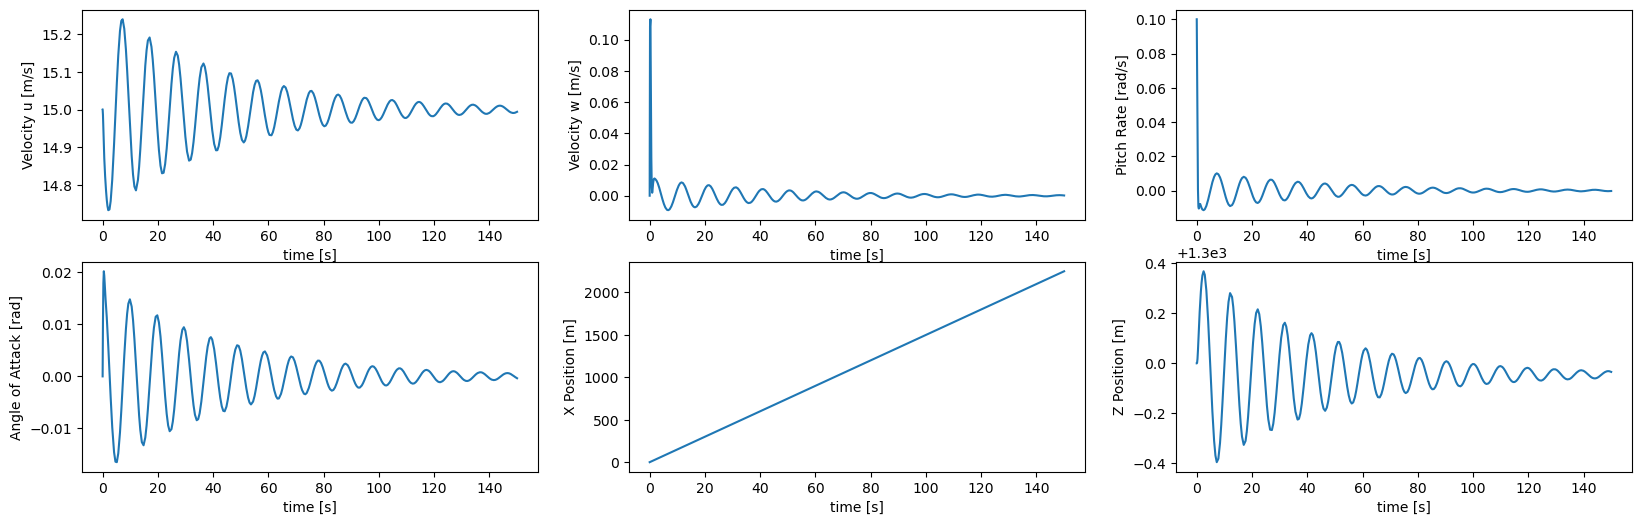

In [12]:
# def Longitudinal_Dynamic_Analysis(aircraft, u0, Iyy, CL0, CLu, CLa, CDu, CMa, CMq, state00, state01, state02, state03, state04, state05, endTime):
#     state0 = [state00, state01, state02, state03, state04, state05]
#     aircraft.longitudinalDynamicStability(u0, Iyy, CL0, CLu, CLa, CDu, CMa, CMq, state0, endTime)

H, Vd = 1300, 15 # cruise alt and speed
endTime = 150 # time to plot response [s]
u0, Iyy, CL0, CLu, CLa, CDu, CMa, CMq = Vd, 0.15544, 0.371, 0.005, 5.39, 0.05, -0.8, -8 # aircraft geometric and stability deratives
state0 = [Vd, 0, 0.1, 0, 0, H] # Initial conditions 
t, u, w, q, theta, x, z = aircraft.longitudinalDynamicStability(u0, Iyy, CL0, CLu, CLa, CDu, CMa, CMq, state0, endTime)

# state00 = ipywidgets.FloatSlider(description='Velocity [m/s]', value=Vd, min=5, max=70, step=0.1, continuous_update=False)
# state01 = ipywidgets.FloatSlider(description='Iyy', value=Iyy, min=0.01, max=1, step=0.01, continuous_update=False)
# state02 = ipywidgets.FloatSlider(description='Iyy', value=0, min=-1, max=1, step=0.01, continuous_update=False)
# state03 = ipywidgets.FloatSlider(description='Iyy', value=0, min=-1, max=1, step=0.01, continuous_update=False)
# state04 = ipywidgets.FloatSlider(description='Iyy', value=0, min=-1, max=1, step=0.01, continuous_update=False)
# state05 = ipywidgets.IntSlider(description='Iyy', value=H, min=0, max=20000, step=1, continuous_update=False)
# endTime = ipywidgets.IntSlider(description='Time [s]', value=endTime, min=0, max=1000, step=1, continuous_update=False)

# widget = ipywidgets.interactive(Longitudinal_Dynamic_Analysis, aircraft=ipywidgets.fixed(aircraft), u0=ipywidgets.fixed(u0), Iyy=ipywidgets.fixed(Iyy), CL0=ipywidgets.fixed(CL0), 
#                                 CLu=ipywidgets.fixed(CLu), CLa=ipywidgets.fixed(CLa), CDu=ipywidgets.fixed(CDu), CMa=ipywidgets.fixed(CMa), CMq=ipywidgets.fixed(CMq),
#                                 state00=state00, state01=state01, state02=state02, state03=state03, state04=state04, state05=state05, endTime=endTime)

# controls = ipywidgets.HBox(widget.children[:-1], layout = ipywidgets.Layout(flex_flow='row wrap'))
# output = widget.children[-1]
# display(ipywidgets.VBox([controls, output]))

In [ ]:
# def aileronSizing(self, c, CLa, CLdai b1, b2)
#     rollDamping = lambda y: c(y) * y**2
#     rollAuthority = lambda y: c(y) * y

#     rollDampingCoefficient = -1((4*(CLa + self.CD0))/(self.Sw*self.wingSpan**2)) * quad(rollDamping, 0, self.wingSpan/2)
#     rollAuthorityDerivative = ((2*CLdai)/(self.Sw*self.wingSpan)) * quad(rollAuthority, b1, b2)  # dCL_dda is the lift slope due to aileron deflection
#     return rollDampingCoefficient, rollAuthorityDerivative

(0.05, 0.33, 2.0)
-0.7702402361469016 0.2643211185620652
(0.05, 0.33, 2.0)


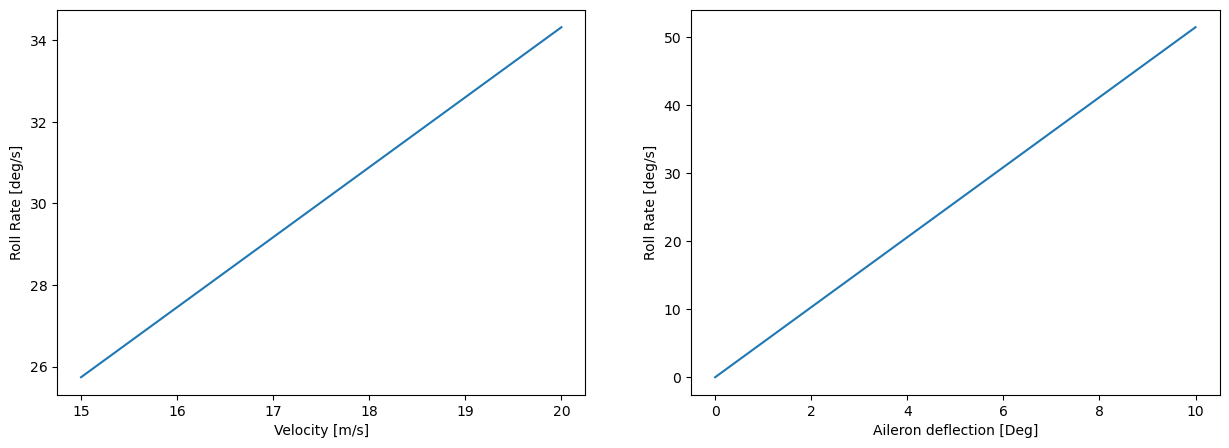

In [14]:
c = aircraft.Get_chord('Side Slip/Wing_Graph_0_Re.txt', 20)
CLa = 5.39
CLdai = 3.89
b1, b2 = 0.6, .8
aileronDeflection = np.deg2rad(5)
rollDampingCoefficient, rollAuthorityDerivative = aircraft.aileronSizing(c, CLa, CLdai, b1, b2)
V = np.linspace(15, 20, 50)
rollRate = -(rollAuthorityDerivative/rollDampingCoefficient)*aileronDeflection * 2*(V/aircraft.wingSpan)
print(rollDampingCoefficient, rollAuthorityDerivative)#, rollRate

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(V, np.rad2deg(rollRate)); ax1.set_xlabel('Velocity [m/s]'); ax1.set_ylabel('Roll Rate [deg/s]')

aileronDeflection = np.linspace(0, 10, 100)
aileronDeflection = np.deg2rad(aileronDeflection)
rollDampingCoefficient, rollAuthorityDerivative = aircraft.aileronSizing(c, CLa, CLdai, b1, b2)
V1 = 15
rollRate2 = -(rollAuthorityDerivative/rollDampingCoefficient)*aileronDeflection * 2*(V1/aircraft.wingSpan)
ax2.plot(np.rad2deg(aileronDeflection), np.rad2deg(rollRate2)); ax2.set_xlabel('Aileron deflection [Deg]'); ax2.set_ylabel('Roll Rate [deg/s]')
plt.show()

In [ ]:
# y = np.linspace(0, 1, 30)
# plt.figure()
# plt.plot(y, c(y))
# plt.show()

In [ ]:
# # Plotting data from XFLR 5
# cl_data = np.loadtxt('Cl_vs_beta.txt', skiprows=1)
# cy_data = np.loadtxt('CY_vs_beta.txt', skiprows=1)
# cn_data = np.loadtxt('Cn_vs_beta.txt', skiprows=1)

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,15))
# ax1.plot(cl_data[:,0], cl_data[:,1], label= 'Current model')
# ax1.plot(cl_data[:,2], cl_data[:,3], label= 'No sweep, no dihedral')
# ax1.plot(cl_data[:,4], cl_data[:,5], marker='*', label= 'No sweep, 25 deg dihedral')
# ax1.plot(cl_data[:,6], cl_data[:,7], label= '20 deg sweep, no dihedral')
# ax1.grid(); ax1.legend(); ax1.set_ylabel('Cl - Roll'); ax1.set_xlabel('Beta [Deg]')

# ax2.plot(cy_data[:,0], cy_data[:,1], label= 'Current model')
# ax2.plot(cy_data[:,2], cy_data[:,3], label= 'No sweep, no dihedral')
# ax2.plot(cy_data[:,4], cy_data[:,5], marker='*', label= 'No sweep, 25 deg dihedral')
# ax2.plot(cy_data[:,6], cy_data[:,7], label= '20 deg sweep, no dihedral')
# ax2.grid(); ax2.legend(); ax2.set_ylabel('CY - Sideforce'); ax2.set_xlabel('Beta [Deg]')

# ax3.plot(cn_data[:,0], cn_data[:,1], label= 'Current model')
# ax3.plot(cn_data[:,2], cn_data[:,3], label= 'No sweep, no dihedral')
# ax3.plot(cn_data[:,4], cn_data[:,5], marker='*', label= 'No sweep, 25 deg dihedral')
# ax3.plot(cn_data[:,6], cn_data[:,7], label= '20 deg sweep, no dihedral')
# ax3.grid(); ax3.legend(); ax3.set_ylabel('Cn - Yaw'); ax3.set_xlabel('Beta [Deg]')
# plt.show()

In [ ]:
# # Plotting data from XFLR 5
# cl_data = np.loadtxt('Data\Aircraft Polar\Wing_Polar_Graph_CL_AOA.txt', skiprows=1)
# cm_data = np.loadtxt('Data\Aircraft Polar\Wing_Polar_Graph_Cm_AOA.txt', skiprows=1)
# clcd_data = np.loadtxt('Data\Aircraft Polar\Wing_Polar_Graph_CL_CD.txt', skiprows=1)
# cl_cd_data = np.loadtxt('Data\Aircraft Polar\Wing_Polar_Graph_CLCD_AOA.txt', skiprows=1)

# fig, ax = plt.subplots(2, 2, figsize=(10,10))
# ax1, ax2, ax3, ax4 = ax[0][0], ax[0][1], ax[1][0], ax[1][1]
# ax1.plot(cl_data[:,0], cl_data[:,1])
# ax1.grid(); ax1.legend(); ax1.set_ylabel('CL - Lift'); ax1.set_xlabel('Alpha [Deg]')

# ax2.plot(cm_data[:,0], cm_data[:,1])
# ax2.grid(); ax2.legend(); ax2.set_ylabel('Cm - Pitch'); ax2.set_xlabel('Alpha [Deg]')

# ax3.plot(clcd_data[:,0], clcd_data[:,1])
# ax3.grid(); ax3.legend(); ax3.set_ylabel('CL'); ax3.set_xlabel('Cd')

# ax4.plot(cl_cd_data[:,0], cl_cd_data[:,1])
# ax4.grid(); ax4.legend(); ax4.set_ylabel('CL/CD'); ax4.set_xlabel('Alpha [Deg]')
# plt.show()

In [ ]:
# # Compare data from XFLR 5 and tool
# u_data = np.loadtxt('Data\Long Response\Time Response u.txt', skiprows=1)
# w_data = np.loadtxt('Data\Long Response\Time Response w.txt', skiprows=1)
# q_data = np.loadtxt('Data\Long Response\Time Response q.txt', skiprows=1)
# t_data = np.loadtxt('Data\Long Response\Time Response t.txt', skiprows=1)

# fig, ax = plt.subplots(2, 3, figsize=(40,20))
# ax0 = ax[0][0].twinx(); ax1 = ax[0][1].twinx(); ax2 = ax[0][2].twinx(); ax3 = ax[1][0].twinx()
# ax[0][0].plot(t,u, label='Tool'); ax[0][0].set_xlabel('time [s]'); ax[0][0].set_ylabel('Velocity u [m/s]'); ax[0][0].legend()
# ax0.plot(u_data[:,0], u_data[:,1], color='r', label='XFLR 5'); ax0.set_ylabel('Velocity u XFLR 5 [m/s]'); ax0.legend()
# ax[0][1].plot(t,w, label='Tool'); ax[0][1].set_xlabel('time [s]'); ax[0][1].set_ylabel('Velocity w [m/s]'); ax[0][1].legend()
# ax1.plot(w_data[:,0], w_data[:,1], color='r', label='XFLR 5'); ax1.set_ylabel('Velocity w XFLR 5 [m/s]')
# ax[0][2].plot(t,q); ax[0][2].set_xlabel('time [s]'); ax[0][2].set_ylabel('Pitch Rate [rad/s]')
# ax2.plot(q_data[:,0], q_data[:,1], color='r', label='XFLR 5'); ax1.set_ylabel('Pitch Rate XFLR 5 [rad/s]')
# ax[1][0].plot(t,theta); ax[1][0].set_xlabel('time [s]'); ax[1][0].set_ylabel('Angle of Attack [rad]')
# ax3.plot(t_data[:,0], t_data[:,1], color='r', label='XFLR 5'); ax3.set_ylabel('Angle of Attack XFLR 5 [rad]')
# ax[1][1].plot(t,x); ax[1][1].set_xlabel('time [s]'); ax[1][1].set_ylabel('X Position [m]')
# ax[1][2].plot(t,z); ax[1][2].set_xlabel('time [s]'); ax[1][2].set_ylabel('Z Position [m]')
# plt.show()

In [ ]:
# # Plotting data from XFLR 5
# v_data = np.loadtxt('Data\Lat Response\Time Response v.txt', skiprows=1)
# p_data = np.loadtxt('Data\Lat Response\Time Response p.txt', skiprows=1)
# r_data = np.loadtxt('Data\Lat Response\Time Response r.txt', skiprows=1)
# phi_data = np.loadtxt('Data\Lat Response\Time Response phi.txt', skiprows=1)

# fig, ax = plt.subplots(2, 2, figsize=(10,10))
# ax1, ax2, ax3, ax4 = ax[0][0], ax[0][1], ax[1][0], ax[1][1]
# ax1.plot(v_data[:,0], v_data[:,1])
# ax1.grid(); ax1.legend(); ax1.set_ylabel('V - Side velocity [m/s]'); ax1.set_xlabel('Time [s]')

# ax2.plot(p_data[:,0], p_data[:,1])
# ax2.grid(); ax2.legend(); ax2.set_ylabel('p - yaw damping [deg/s]'); ax2.set_xlabel('Time [s]')

# ax3.plot(r_data[:,0], r_data[:,1])
# ax3.grid(); ax3.legend(); ax3.set_ylabel('r - roll damping [deg/s]'); ax3.set_xlabel('Time [s]')

# ax4.plot(phi_data[:,0], phi_data[:,1])
# ax4.grid(); ax4.legend(); ax4.set_ylabel('phi - bank angle damping [deg/s]'); ax4.set_xlabel('Time [s]')
# plt.show()

In [ ]:
# # Plotting data from XFLR 5
# v_data = np.loadtxt('Data\Lat Response\Time Response v2.txt', skiprows=1)
# p_data = np.loadtxt('Data\Lat Response\Time Response p2.txt', skiprows=1)
# r_data = np.loadtxt('Data\Lat Response\Time Response r2.txt', skiprows=1)
# phi_data = np.loadtxt('Data\Lat Response\Time Response phi2.txt', skiprows=1)

# fig, ax = plt.subplots(2, 2, figsize=(10,10))
# ax1, ax2, ax3, ax4 = ax[0][0], ax[0][1], ax[1][0], ax[1][1]
# ax1.plot(v_data[:,0], v_data[:,1])
# ax1.grid(); ax1.legend(); ax1.set_ylabel('V - Side velocity [m/s]'); ax1.set_xlabel('Time [s]')

# ax2.plot(p_data[:,0], p_data[:,1])
# ax2.grid(); ax2.legend(); ax2.set_ylabel('p - yaw damping [deg/s]'); ax2.set_xlabel('Time [s]')

# ax3.plot(r_data[:,0], r_data[:,1])
# ax3.grid(); ax3.legend(); ax3.set_ylabel('r - roll damping [deg/s]'); ax3.set_xlabel('Time [s]')

# ax4.plot(phi_data[:,0], phi_data[:,1])
# ax4.grid(); ax4.legend(); ax4.set_ylabel('phi - bank angle damping [deg/s]'); ax4.set_xlabel('Time [s]')
# plt.show()